# Crack detection in buildings using artificial intelligence

In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import os
import glob
from torch.utils.data import Dataset,DataLoader
import torch
from torch import optim
import torch.nn as nn
from torchvision.transforms import transforms

In [44]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

In [3]:
class Dataset(Dataset):
    
    def __init__(self,transform=None,train=True):
        negative='Negative'
        positive='Positive'
        negative_files=[os.path.join(negative,file) for file in os.listdir(negative) if file.endswith('.jpg')]
        negative_files.sort()
        positive_files=[os.path.join(positive,file) for file in os.listdir(positive) if file.endswith('.jpg')]
        positive_files.sort()
        number_of_samples=len(negative_files)+len(positive_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        self.transform = transform
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)
    
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
    

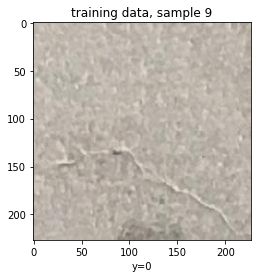

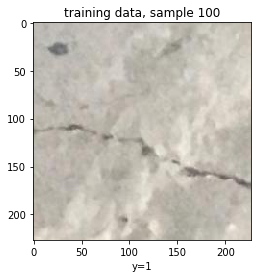

In [19]:
dataset=Dataset()
samples=[9,100]
for sample  in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()

#  Simple Linear model

In [59]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])

In [20]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [21]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [22]:
size_of_image=3*227*227
size_of_image

154587

In [25]:
class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        out = self.linear(x)
        return out

In [34]:
input_dim=227*227*3
output_dim=2
torch.manual_seed(0)
model=SoftMax(input_dim,output_dim)
learning_rate=0.1
#momentum=0.1
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.1)
criterion=nn.CrossEntropyLoss()
train_loader=DataLoader(dataset=dataset_train,batch_size=1000)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=1000)


In [40]:
#train
n_epochs=3
accuracy_list=[]
N_test=len(dataset_val)
def train_model(n_epochs):
    epoch_completed=0
    for epoch in range(n_epochs):
        for x,y in train_loader:
            optimizer.zero_grad()
            z=model(x.view(-1,input_dim))
            loss=criterion(z,y)
            loss.backward()
            optimizer.step()
    correct=0
    for epoch in range(n_epochs):
        for x_test,y_test in validation_loader:
            z=model(x_test.view(-1,input_dim))
            _,yhat=torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy=correct/N_test
        accuracy_list.append(accuracy)
        epoch_completed+=1
        print(f"Epochs completed {epoch_completed}")
    
     
train_model(n_epochs)

Epochs completed 1
Epochs completed 2
Epochs completed 3


In [41]:
accuracy_list

[0.6283, 1.2566, 1.8849]

# Pre-trained model

In [61]:
from torchvision import models
#dir(models)

In [62]:
model=models.resnet18(pretrained=True).to(device)

In [63]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform =transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean, std)])

In [64]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [65]:
#Using pre_trained models not updating the parmeters
for param in model.parameters():
    param.requries_grad=False

In [67]:
model.fc=nn.Linear(512,2)
model=model.to(device)

In [68]:
train_loader=DataLoader(dataset=dataset_train,batch_size=50)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=50)

In [69]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam([param for param in model.parameters() if param.requires_grad],lr=0.001)

In [70]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [71]:
device=torch.device("cuda:0")
device

device(type='cuda', index=0)

In [72]:
n_epochs=5
accuracy_list=[]
loss_list=[]
correct=0
n_test=len(dataset_val)
def train_model(n_epochs):
    epoch_completed=0
    for epoch in range(n_epochs):
        for x,y in train_loader:
            model.train()
            optimizer.zero_grad()
            x=x.to(device)
            y=y.to(device)
            z=model(x)
            loss=criterion(z,y)
            loss.backward()
            optimizer.step()
            print("batch_done")
        correct=0
        for x_test,y_test in validation_loader:
            model.eval()
            x_test=x_test.to(device)
            y_test=y_test.to(device)
            z=model(x_test)
            _,yhat=torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy=correct/n_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
        epoch_completed+=1
        print(f"Epochs completed {epoch_completed}")

In [73]:
train_model(n_epochs)

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
Epochs completed 5


In [74]:
accuracy_list

[0.9963, 0.998, 0.9952, 0.9934, 0.9954]

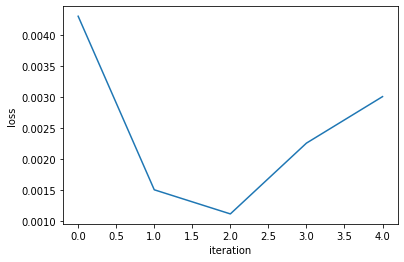

In [75]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [78]:
#first four missclassified samples
count=0
for i,(x,y) in enumerate(dataset_val):
    x=x.unsqueeze(0)
    x=x.to(device)
    z=model(x)
    _,yhat=torch.max(z,1)
    if yhat!=y:
        print(f"sample {i} predicted value: {yhat} actual value:{y}")
        count+=1
    if count>4:
        break
        

sample 283 predicted value: tensor([1], device='cuda:0') actual value:0
sample 451 predicted value: tensor([1], device='cuda:0') actual value:0
sample 794 predicted value: tensor([0], device='cuda:0') actual value:1
sample 1035 predicted value: tensor([1], device='cuda:0') actual value:0
sample 1116 predicted value: tensor([0], device='cuda:0') actual value:1


In [79]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  